In [1]:
# Imports

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

plt.ion()   # interactive mode

# Refernce notebook: https://jovian.ai/ahmadyahya11/pytorch-transfer-learning

In [2]:
# Data locations, with off the shelf loader
from torchvision import datasets

root = "data_pipeline/deepfashion/"
train = os.path.join(root, "train")
test = os.path.join(root, "test")
validation = os.path.join(root, "validation")

print(len(os.listdir(f"{train}/image")))
print(len(os.listdir(f"{test}/image")))
print(len(os.listdir(f"{validation}/image")))

191961
62629
32153


In [3]:
# Labels
labels = {
    1: "short_sleeve_top",
    2: "long_sleeve_top",
    3: "short_sleeve_outwear",
    4: "long_sleeve_outwear",
    5: "vest",
    6: "sling",
    7: "shorts",
    8: "trousers",
    9: "skirt",
    10: "short_sleeve_dress",
    11: "long_sleeve_dress",
    12: "vest_dress",
    13: "sling_dress",
}

In [4]:
# Sample annotation
import json

anno = json.load(open("/home/rajkinra23/git/drip_vision/data_pipeline/deepfashion/train/annos/178255.json"))
labels = []
for k in anno:
    if k.startswith('item'):
        item = anno.get(k)
        print(item.get('category_id'), item.get('bounding_box'))
        labels.append(item.get('category_name'))
        
print(anno.keys())
print(labels)

7 [80, 321, 328, 544]
1 [53, 62, 353, 350]
dict_keys(['item2', 'source', 'pair_id', 'item1'])
['shorts', 'short sleeve top']


In [5]:
# Dataloader for the deepfashion dataset

import os
import numpy as np
import torch
import json
from PIL import Image

INPUT_W = 224
INPUT_H = 224

# Util to transform a box
def resize_box(box, w, h):
    x_a, y_a, x_b, y_b = box
    x_a *= INPUT_W/w
    x_b *= INPUT_W/w
    y_a *= INPUT_H/h
    y_b *= INPUT_H/h
    return (x_a, y_a, x_b, y_b)

# Util for area of a box, make sure that it's not 0
def area(box):
    x_a, y_a, x_b, y_b = box
    area = (y_b - y_a) * (x_b - x_a)
    return area    

# Dataset class
class DeepfashionDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        # Root directory
        self.root = root
        
        # Transforms
        self.transforms = transforms
        
        # Load the images and the annotations
        self.image_root = os.path.join(root, "image")
        self.annos_root = os.path.join(root, "annos")
        self.imgs = list(sorted(os.listdir(self.image_root)))
        self.annos = list(sorted(os.listdir(self.annos_root)))

    def __getitem__(self, idx):
        # Get the image and correpsonding annotations
        img_path = os.path.join(self.image_root, self.imgs[idx])
        anno_path = os.path.join(self.annos_root, self.annos[idx])
        img = Image.open(img_path).convert("RGB")
        w, h = img.size
        anno = json.load(open(anno_path))

        # Get the bounding box and label for each iden
        labels = []
        boxes = []
        for k in anno:
            if k.startswith('item'):
                # Get the item, and bounding box and label from said item
                item = anno[k]
                label = item.get('category_name')
                box = item.get('bounding_box')
                
                # Add box and label to accumulated list, if the box has a non zero area.
                if area(box) > 0.0:
                    labels.append(label)
                    boxes.append(box)
        
        # Apply transforms if supplied
        if self.transforms is not None:
            img = self.transforms(img)
            for i in range(len(boxes)):
                boxes[i] = resize_box(boxes[i], w, h)
            
        # Tensorize boxes
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # Index can basically serve as the image id
        image_id = torch.tensor([idx])
        
        # Build the target
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        
        # Return the image and the target labels/boxes
        return img, target

    def __len__(self):
        return len(self.imgs)
    
# Transformer for input. VGG takes 224 x 224 image sizes.
transform = transforms.Compose([transforms.Resize((INPUT_W, INPUT_H)), 
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


In [6]:
ds = DeepfashionDataset(train, transform)
print(ds[0])

(tensor([[[-0.8902, -0.8824, -0.8902,  ...,  0.7098,  0.8431,  0.9608],
         [-0.8824, -0.8824, -0.8824,  ...,  0.8824,  0.9608,  0.9922],
         [-0.8667, -0.8667, -0.8588,  ...,  0.9843,  0.9922,  0.9843],
         ...,
         [ 0.9059,  0.9059,  0.9059,  ..., -0.4196, -0.1922, -0.1843],
         [ 0.9137,  0.9137,  0.9137,  ..., -0.5765, -0.2549, -0.2314],
         [ 0.9059,  0.9059,  0.9059,  ..., -0.7333, -0.3882, -0.2784]],

        [[-0.6627, -0.6549, -0.6627,  ...,  0.7176,  0.8510,  0.9608],
         [-0.6549, -0.6549, -0.6549,  ...,  0.8902,  0.9608,  0.9922],
         [-0.6392, -0.6392, -0.6314,  ...,  0.9843,  0.9922,  0.9843],
         ...,
         [ 0.9137,  0.9137,  0.9137,  ..., -0.3412, -0.1843, -0.2000],
         [ 0.9216,  0.9216,  0.9216,  ..., -0.4667, -0.2235, -0.2157],
         [ 0.9137,  0.9137,  0.9137,  ..., -0.5843, -0.3176, -0.2392]],

        [[-0.6000, -0.5922, -0.6000,  ...,  0.6784,  0.8353,  0.9608],
         [-0.5922, -0.5922, -0.5922,  ...,  

In [7]:
# Visualize some of the data
from PIL import Image, ImageDraw, ImageFont

def visualize(datapoint):
    # Get image tensor and target
    img, target = datapoint
    
    # Convert image to PIL
    img = transforms.ToPILImage()(img)
    
    # Annotate and draw
    annotated_image = img
    draw = ImageDraw.Draw(annotated_image)
    font = ImageFont.truetype("./calibril.ttf", 15)

    # Draw boxestop_labels, boxes, scores)
    for box in target.get("boxes"):
        box = box.tolist()
        draw.rectangle(xy=box, outline='#000000')
        draw.rectangle(xy=[l + 1. for l in box], outline='#000000')
        
    # Return image
    return annotated_image
        
visualize(ds[33])
print(ds[33][1])
s = "short sleeve top,long sleeve top,short sleeve outwear,long sleeve outwear,vest,sling,shorts,trousers,skirt,short sleeve dress,long sleeve dress,vest dress,sling dress"
labels = s.split(",")
print(labels)

{'boxes': tensor([[108.1500,   0.0000, 216.6500,  56.4667],
        [ 85.4000,  40.3667, 191.8000, 103.8333]]), 'labels': ['short sleeve top', 'shorts'], 'image_id': tensor([33])}
['short sleeve top', 'long sleeve top', 'short sleeve outwear', 'long sleeve outwear', 'vest', 'sling', 'shorts', 'trousers', 'skirt', 'short sleeve dress', 'long sleeve dress', 'vest dress', 'sling dress']


Found checkpoints: ['checkpoints/deep_fashion_detector_epoch_0.pth', 'checkpoints/deep_fashion_detector_epoch_1.pth', 'checkpoints/deep_fashion_detector_epoch_2.pth', 'checkpoints/deep_fashion_detector_epoch_3.pth', 'checkpoints/deep_fashion_detector_epoch_4.pth', 'checkpoints/deep_fashion_detector_epoch_5.pth', 'checkpoints/deep_fashion_detector_epoch_6.pth', 'checkpoints/deep_fashion_detector_epoch_7.pth', 'checkpoints/deep_fashion_detector_epoch_8.pth']
Loaded model from: checkpoints/deep_fashion_detector_epoch_8.pth
Training deep_fashion_detector_epoch_9.pth
Epoch 1 of 1
Begin iterating over training dataset


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47991/47991 [3:48:41<00:00,  3.50it/s]


Begin iterating over validation dataset


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32153/32153 [22:17<00:00, 24.04it/s]


Loss: 0.15680867884141492


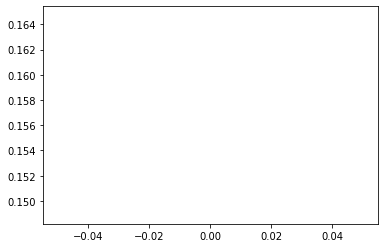

Saving model!
Found checkpoints: ['checkpoints/deep_fashion_detector_epoch_0.pth', 'checkpoints/deep_fashion_detector_epoch_1.pth', 'checkpoints/deep_fashion_detector_epoch_2.pth', 'checkpoints/deep_fashion_detector_epoch_3.pth', 'checkpoints/deep_fashion_detector_epoch_4.pth', 'checkpoints/deep_fashion_detector_epoch_5.pth', 'checkpoints/deep_fashion_detector_epoch_6.pth', 'checkpoints/deep_fashion_detector_epoch_7.pth', 'checkpoints/deep_fashion_detector_epoch_8.pth', 'checkpoints/deep_fashion_detector_epoch_9.pth']
Loaded model from: checkpoints/deep_fashion_detector_epoch_9.pth
Training deep_fashion_detector_epoch_10.pth
Epoch 1 of 1
Begin iterating over training dataset


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47991/47991 [3:37:04<00:00,  3.68it/s]


Begin iterating over validation dataset


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32153/32153 [21:44<00:00, 24.64it/s]

Loss: 0.14966257681682985


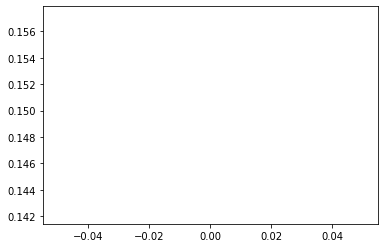

Saving model!
Found checkpoints: ['checkpoints/deep_fashion_detector_epoch_0.pth', 'checkpoints/deep_fashion_detector_epoch_1.pth', 'checkpoints/deep_fashion_detector_epoch_10.pth', 'checkpoints/deep_fashion_detector_epoch_2.pth', 'checkpoints/deep_fashion_detector_epoch_3.pth', 'checkpoints/deep_fashion_detector_epoch_4.pth', 'checkpoints/deep_fashion_detector_epoch_5.pth', 'checkpoints/deep_fashion_detector_epoch_6.pth', 'checkpoints/deep_fashion_detector_epoch_7.pth', 'checkpoints/deep_fashion_detector_epoch_8.pth', 'checkpoints/deep_fashion_detector_epoch_9.pth']
Loaded model from: checkpoints/deep_fashion_detector_epoch_9.pth
Training deep_fashion_detector_epoch_11.pth
Epoch 1 of 1
Begin iterating over training dataset


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 45887/47991 [3:57:33<10:53,  3.22it/s]


KeyboardInterrupt: 

In [9]:
# Train using detecto (maybe)
from detecto.core import Model, DataLoader
from detecto import utils, visualize

# Clear torch cache
torch.cuda.empty_cache()

# Get the train dataset
train_dataset = DeepfashionDataset(train, transform)
validation_dataset = DeepfashionDataset(validation, transform)

# Loaders
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Train model. Let's save between every epoch so that we can continue from there if needed
checkpoint_dir = "checkpoints"
checkpoint_prefix = "deep_fashion_detector_epoch"
for _ in range(5):
    # If there are no checkpoints, start a fresh model
    checkpoints = []
    for f in os.listdir(checkpoint_dir):
        if f.startswith(checkpoint_prefix):
            checkpoints.append(os.path.join(checkpoint_dir, f))
        checkpoints.sort()
    print("Found checkpoints: {}".format(checkpoints))
    if not checkpoints:
        model = Model(labels)
        epoch = 0
    
    # Otherwise, load from the latest checkpoint
    else:
        latest_checkpoint = checkpoints[-1]
        model = Model.load(latest_checkpoint, labels)
        epoch = len(checkpoints)
        print("Loaded model from: {}".format(latest_checkpoint))
    
    # Train an epoch
    next_checkpoint = f'{checkpoint_prefix}_{epoch}.pth'
    print("Training {}".format(next_checkpoint))
    losses = model.fit(train_dataloader, validation_dataset, epochs=1,
                       learning_rate=0.001, verbose=True)

    # Visualize loss during training
    plt.plot(losses)
    plt.show()

    # Save model
    print("Saving model!")
    model.save(os.path.join(checkpoint_dir, next_checkpoint))

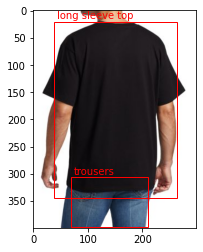

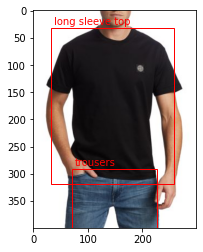

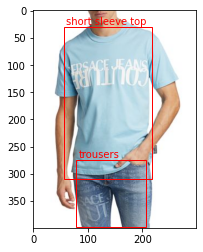

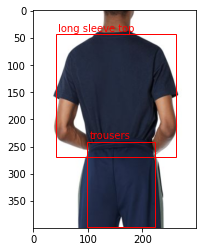

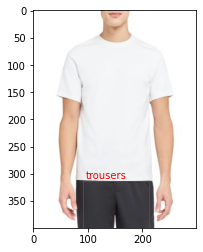

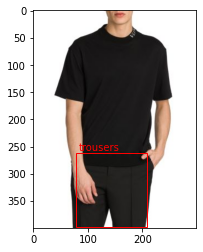

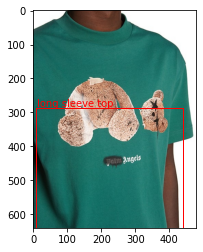

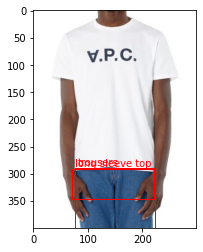

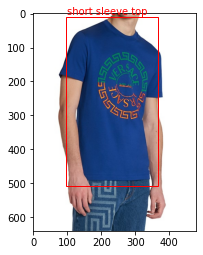

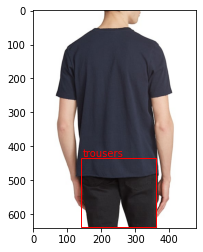

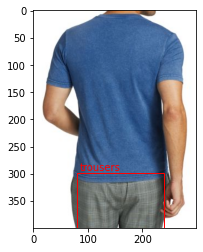

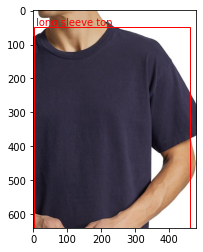

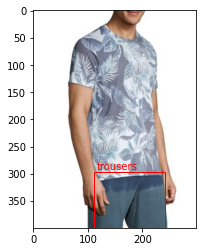

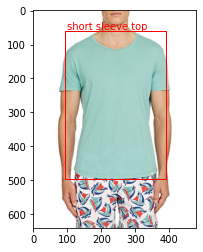

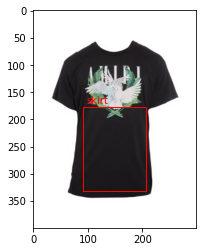

In [8]:
# Try visualizing model on the embeddings dataset
from detecto import utils, visualize
from detecto.core import Model, DataLoader
import random
import os

s = "short sleeve top,long sleeve top,short sleeve outwear,long sleeve outwear,vest,sling,shorts,trousers,skirt,short sleeve dress,long sleeve dress,vest dress,sling dress"
labels = s.split(",")

def random_image():
    root = "/home/rajkinra23/git/drip_vision/data_pipeline/dataset/train"
    product_ids = os.listdir(root) 
    random_prodict_id = os.path.join(root, random.choice(product_ids))
    product_dir = os.path.join(root, random_prodict_id)
    images = os.listdir(product_dir)
    random_image = os.path.join(product_dir, random.choice(images))
    return random_image

checkpoint = 'checkpoints/deep_fashion_detector_epoch_8.pth'
model = Model.load(checkpoint, labels)
for _ in range(40):
    img = random_image()
    image = utils.read_image(img)
    top_labels, boxes, scores = model.predict(image)
    threshold = 0.6
    i = 0
    if len(scores) > 0:
        while i < len(scores) and scores[i] >= threshold:
            i += 1
        if i > 0:
            visualize.show_labeled_image(image, boxes[:i], top_labels[:i])

['trousers', 'long sleeve top', 'trousers', 'skirt', 'long sleeve top', 'long sleeve outwear', 'long sleeve dress', 'long sleeve outwear', 'long sleeve top', 'long sleeve top', 'long sleeve top', 'trousers', 'long sleeve dress', 'short sleeve top', 'long sleeve top', 'long sleeve outwear'] tensor([[ 149.1384,  692.7540,  464.1073, 1179.4739],
        [  61.7706,  149.5928,  522.9556,  733.0873],
        [ 202.4788,  872.2112,  419.2842, 1177.8748],
        [ 140.2512,  155.3766,  518.0049,  645.8455],
        [ 163.0343,    8.6838,  532.6745,  311.7121],
        [  77.3260,  525.0981,  535.0527, 1156.4678],
        [  68.0207,   77.6062,  525.1838,  647.1157],
        [  50.2535,  104.4663,  519.7711,  710.7034],
        [ 126.4316,  304.4276,  518.9779, 1045.7593],
        [ 152.0513,  501.5319,  519.5701,  829.9151],
        [ 294.3441,    3.3420,  542.3118,  235.4159],
        [ 114.7898,  155.7340,  517.2617,  645.6970],
        [  71.7607,  530.0616,  535.9427, 1165.1299],
       

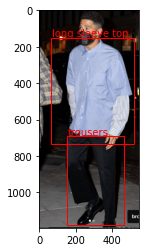

In [10]:
# One off debugging


img = "/home/rajkinra23/Documents/BOOK.png"
image = utils.read_image(img)
top_labels, boxes, scores = model.predict(image)
threshold = 0.6
i = 0
print(top_labels, boxes, scores)
if len(scores) > 0:
    while scores[i] >= threshold:
        i += 1
    if i > 0:
        visualize.show_labeled_image(image, boxes[:i], top_labels[:i])